<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/minor_fix/projects/ComputerVision/Image_Alignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Alignment

**By Neuromatch Academy**

__Content creators:__ Kaleb Vinehout

__Production editor:__ Spiros Chavlis

---
# Objective

This notebook will give you starting points to perform Spatial Transformers. These can be used for registraion of images. This is useful when comparing multiple datasets together. Check out [Jaderberg et al., 2015](https://arxiv.org/abs/1506.02025) for more details.These can also be used to plug into any CNN architecture to deal with dataset rotations and scale invariance in a given dataset

* Spatial transformers contain three main parts.The first is a localizaion net the second is grid generator and the last is a sampler.

---
# Intro to Image Alignment
  

## Image Alignment Applications
* To answer many biological questions, it is necessary to align sets of images together
* Use Spatial Transfomers as a preprocessing step for any CNN achitecutre. This could be done before facial recognition in order to crop and align images before spatial recognition.

## Acknowledgments:
This Notebook was developed by Kaleb Vinehout. It borrows from material by Ghassen Hamrouni, Asror Wali, and Erwin Russel.

---
# Setup

In [1]:
# @title Install dependencies
!pip install scikit-image --quiet
!pip install Pillow --quiet
!pip install n2v --quiet
!pip install csbdeep --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 32.2 MB/s eta 0:00:00


In [2]:
# Imports
import glob
import time
import sklearn.decomposition

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms

from PIL import Image
from skimage.util import random_noise

In [3]:
# @title Figure settings
%matplotlib inline
plt.ion()  # interactive mode

In [4]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [5]:
device = set_device()

GPU is enabled in this notebook. 
If you want to disable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `None` from the dropdown menu


---
# Data loading

## Loader for classic MNIST as an example

In [6]:
# @title Download MNIST dataset
import tarfile, requests, os

fname = 'MNIST.tar.gz'
name = 'MNIST'
url = 'https://osf.io/y2fj6/download'

if not os.path.exists(name):
  print('\nDownloading MNIST dataset...')
  r = requests.get(url, allow_redirects=True)
  with open(fname, 'wb') as fh:
    fh.write(r.content)
  print('\nDownloading MNIST completed.')

if not os.path.exists(name):
  with tarfile.open(fname) as tar:
    tar.extractall()
    os.remove(fname)
else:
  print('MNIST dataset is dowloaded.')

In [7]:
# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=False,
                   transform=transforms.Compose([
                                                 transforms.ToTensor(),
                                                 transforms.Normalize((0.1307, ), (0.3081, ))
                                                 ])),
                                           batch_size=64,
                                           shuffle=True,
                                           num_workers=2)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, download=False,
                   transform=transforms.Compose([
                                                 transforms.ToTensor(),
                                                 transforms.Normalize((0.1307, ), (0.3081, ))
                                                 ])),
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=2)

Define functions to convert between Tensor and numpy image

In [8]:
def convert_image_np(inp):
  """Convert a Tensor to numpy image."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  return inp

In [9]:
def convert2tensor(self, args):
  data = np.asarray([e[0] for e in self.binary_train_dataset])
  target = np.asarray([e[1] for e in self.binary_train_dataset])

  tensor_data = torch.from_numpy(data)
  tensor_data = tensor_data.float()
  tensor_target = torch.from_numpy(target)

  train = torch.utils.data.TensorDataset(tensor_data, tensor_target)
  train_loader = torch.utils.data.DataLoader(train, batch_size=args.batch_size,
                                             shuffle=True)
  return train_loader

Plot the data

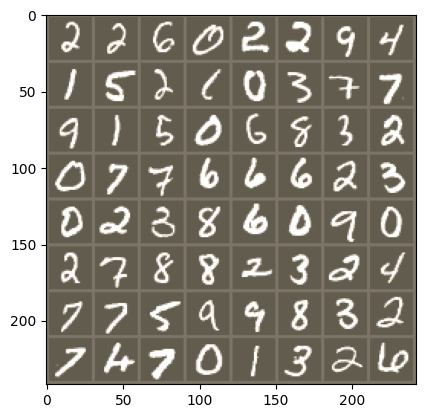

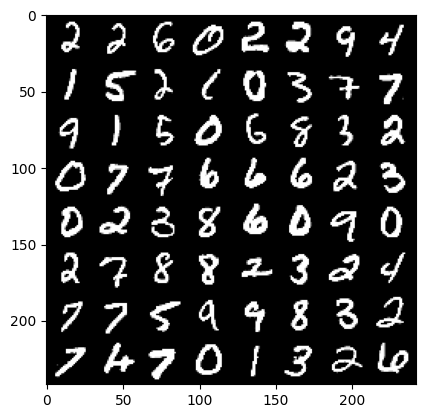

In [10]:
## Display Images
# Get a batch of training data
data = next(iter(test_loader))[0].to(device)
input_tensor = data.cpu()
in_grid = convert_image_np(torchvision.utils.make_grid(input_tensor))

# Plot the images
plt.figure()
plt.imshow(in_grid)
plt.show()

# plot ONE image
plt.figure()
plt.imshow(torchvision.utils.make_grid(input_tensor).numpy().transpose((1, 2, 0)))
plt.show()

---
# Spatial Transformer on images



## Spatial Transformer Network

In [11]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

    # Spatial transformer localization-network
    self.localization = nn.Sequential(
        nn.Conv2d(1, 8, kernel_size=7),
        nn.MaxPool2d(2, stride=2),
        nn.ReLU(True),
        nn.Conv2d(8, 10, kernel_size=5),
        nn.MaxPool2d(2, stride=2),
        nn.ReLU(True)
    )

    # Regressor for the 3 * 2 affine matrix
    self.fc_loc = nn.Sequential(
        nn.Linear(10 * 3 * 3, 32),
        nn.ReLU(True),
        nn.Linear(32, 3 * 2)
    )

    # Initialize the weights/bias with identity transformation
    self.fc_loc[2].weight.data.zero_()
    self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

  # Spatial transformer network forward function
  def stn(self, x):
    xs = self.localization(x)
    xs = xs.view(-1, 10 * 3 * 3)
    theta = self.fc_loc(xs)
    theta = theta.view(-1, 2, 3)

    grid = F.affine_grid(theta, x.size(), align_corners=True)
    x = F.grid_sample(x, grid, align_corners=True)

    return x

  def forward(self, x):
    # transform the input
    x = self.stn(x)

    # Perform the usual forward pass
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

## Train and Test functions for the STN

In [12]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)

### Train function

In [13]:
def train(train_loader, optimizer, epoch, device):

  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 500 == 0:
      print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}"
            f"({(100. * batch_idx / len(train_loader)):.0f}%)]\tLoss: {loss.item():.6f}")

### Test function

In [14]:
def test(test_loader, device):

  with torch.no_grad():
    model.eval()
    test_loss, correct = 0, 0

    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)

      # sum up batch loss
      test_loss += F.nll_loss(output, target, size_average=False).item()
      # get the index of the max log-probability
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}"
          f"({(100. * correct / len(test_loader.dataset)):.0f}%)\n")

### Run Train and test the data

In [15]:
num_epochs = 4  # Original was set to 20. It has been reduced for debugging purposes.
for epoch in range(1, num_epochs + 1):
  train(train_loader, optimizer, epoch, device)
  test(test_loader, device)

Train Epoch: 1 [0/60000(0%)]	Loss: 2.348677
Train Epoch: 1 [32000/60000(53%)]	Loss: 1.057975


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.2208, Accuracy: 9385/10000(94%)

Train Epoch: 2 [0/60000(0%)]	Loss: 0.368327
Train Epoch: 2 [32000/60000(53%)]	Loss: 0.431354

Test set: Average loss: 0.1351, Accuracy: 9616/10000(96%)

Train Epoch: 3 [0/60000(0%)]	Loss: 0.301837
Train Epoch: 3 [32000/60000(53%)]	Loss: 0.149378

Test set: Average loss: 0.0963, Accuracy: 9691/10000(97%)

Train Epoch: 4 [0/60000(0%)]	Loss: 0.128701
Train Epoch: 4 [32000/60000(53%)]	Loss: 0.150764

Test set: Average loss: 0.2238, Accuracy: 9313/10000(93%)



### Visualize the results

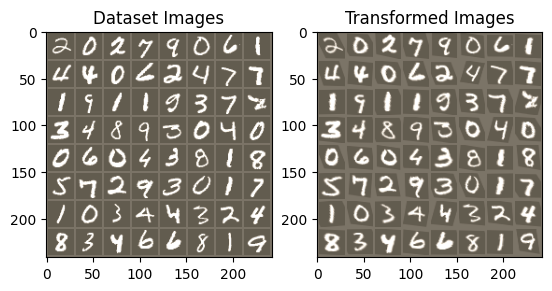

In [16]:
def visualize_stn():
  with torch.no_grad():
    # Get a batch of training data
    data = next(iter(test_loader))[0].to(device)

    input_tensor = data.cpu()
    transformed_input_tensor = model.stn(data).cpu()

    in_grid = convert_image_np(
        torchvision.utils.make_grid(input_tensor))

    out_grid = convert_image_np(
        torchvision.utils.make_grid(transformed_input_tensor))

    # Plot the results side-by-side
    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(in_grid)
    axarr[0].set_title('Dataset Images')

    axarr[1].imshow(out_grid)
    axarr[1].set_title('Transformed Images')
  return in_grid, out_grid


# Visualize the STN transformation on some input batch
[in_grid, out_grid] = visualize_stn()
plt.ioff()
plt.show()

Check out [WNet github repo](https://aswali.github.io/WNet/) and [Xia and Kulis, 2017](https://arxiv.org/abs/1711.08506).

# Optional functions to use when examining effects of spatial transformer

## Function for the Sorensen–Dice coefficient (DSC) to calculate the simularity of images

Function to Compare similarity of images

Compare the similarity of two images with the the Sørensen–Dice coefficient. See details [here](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient).




In [17]:
def calc_dice(im1,im2):
    """
   This calculates the DICE between two images. The maximum DICE is 1, the minimum is Zero.
        Args:
        -	im1, im2: one of the imges to calcualte DICE coeffeicnet. Note image1.shape has to equal image2.shape
        Returns:
        -	dice: the dice coeffeicent
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    dice = 2. * intersection.sum() / (im1.sum() + im2.sum())

    print("The Dice is {}".format(dice))

    return dice

## Function to Add salt/pepper noise to the dataset

add noise class

In [18]:
def salt_pepper_noise(trainloader):
  for data in trainloader:
    img, _ = data[0], data[1]
    s_and_p = torch.tensor(random_noise(img, mode='s&p',
                                        salt_vs_pepper=0.5, clip=True))
  return s_and_p

Question: Are there other types of noise you can add? What effect do different types of noise have? E.g., gasusian

Add noise to both train and test datasets.

## Function to remove noise with noise2void

Import `noise2void` dependances, check out [n2v github repo](https://github.com/juglab/n2v) for details.

In [19]:
# @title Import `noise2void` dependances
from n2v.models import N2VConfig, N2V
from csbdeep.utils import plot_history
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator

### Create a denoising fucntion

In [20]:
def noise2void(data, model_name, patch_size=64):
  """
  Removes noise in 3d image using the noise 2 void method.
  Based on https://arxiv.org/abs/1811.10980 w/ this implementation: https://github.com/juglab/n2v
    Args:
    -	data: Numpy array  2d to be deionised
    -   model: name of model to load, if provided this model is used to denoise instead of model made from data otherwise this is name given to model (ex:#model_name = 'n2v_3D_blk')
    -patch_size: this is the size of patches in X and Y, default is 64
    Returns:
    -	data_denoise: Numpy array noise removed
  """
  # We create our DataGenerator-object.
  datagen = N2V_DataGenerator()
  # In the 'dims' parameter we specify the order of dimensions in the image files we are reading.
  if data.ndim == 2:
    print('2D image found to denosie')
    dataZYX = data
    data_exp = np.expand_dims(dataZYX, axis=(0, 1, 4))  # expand dimensions One at the front is used to hold a potential stack of images such as a movie, One at the end could hold color channels such as RGB. #expand dimensions One at the front is used to hold a potential stack of images such as a movie, One at the end could hold color channels such as RGB.
    patch_shape = (patch_size, patch_size)
    model_axis = 'YX'
  print('arrary with extra dimensions is size of {}'.format(data_exp.shape))
  print('patches are {}'.format(patch_shape))
  # the base directory in which our model will live
  basedir = 'models'
  path = basedir + '/' + model_name
  if not os.path.exists(path):
    print(path)
    # create model
    patches = datagen.generate_patches_from_list(data_exp, shape=patch_shape)
    print('patches shape {}'.format(patches.shape))
    # Patches are created so they do not overlap.
    # (Note: this is not the case if you specify a number of patches. See the docstring for details!)
    # Non-overlapping patches enable us to split them into a training and validation set.
    # modify split so set as a %
    perc_95 = int(patches.shape[0] * 0.95)
    X = patches[:perc_95]  # this is 600/640
    X_val = patches[perc_95:]  # this is 40/640

    # train model
    # You can increase "train_steps_per_epoch" to get even better results at the price of longer computation.
    fast = 128  # default
    slow = 50  # to get better results?  --> apply same model to Z plane
    speed = fast
    config = N2VConfig(X, unet_kern_size=3,
                       train_steps_per_epoch=int(X.shape[0] / speed),
                       train_epochs=20,
                       train_loss='mse',
                       batch_norm=True,
                       train_batch_size=4,
                       n2v_perc_pix=0.198,
                       n2v_patch_shape=patch_shape,
                       n2v_manipulator='uniform_withCP',
                       n2v_neighborhood_radius=5)

    # Let's look at the parameters stored in the config-object.
    vars(config)
    # We are now creating our network model.
    model = N2V(config=config, name=model_name, basedir=basedir)
    history = model.train(X, X_val)
    print(sorted(list(history.history.keys())))
    model.export_TF(name='Noise2Void - data',
                    description='This is the 3D Noise2Void for  data.',
                    authors=["Kaleb Vinehout"],
                    test_img=X_val[0, ..., 0], axes=model_axis,
                    patch_shape=patch_shape)
  # run prediction model on rest of data in 3D image
  # A previously trained model is loaded by creating a new N2V-object without providing a 'config'.
  model = N2V(config=None, name=model_name, basedir=basedir)
  # Here we process the data.
  # The 'n_tiles' parameter can be used if images are too big for the GPU memory.
  # If we do not provide the 'n_tiles' parameter the system will automatically try to find an appropriate tiling.
  data_denoise = model.predict(dataZYX, axes=model_axis)  # , n_tiles=(2, 4, 4))

  return data_denoise

## Function to Segment image with W-net

Check out [WNet github repo](https://aswali.github.io/WNet/) and [Xia and Kulis, 2017](https://arxiv.org/abs/1711.08506).

### The Wnet Class

In [21]:
class Block(nn.Module):
  def __init__(self, in_filters, out_filters, seperable=True):
    super(Block, self).__init__()

    if seperable:
      self.spatial1 = nn.Conv2d(in_filters, in_filters, kernel_size=3, groups=in_filters, padding=1)
      self.depth1 = nn.Conv2d(in_filters, out_filters, kernel_size=1)

      self.conv1 = lambda x: self.depth1(self.spatial1(x))

      self.spatial2 = nn.Conv2d(out_filters, out_filters, kernel_size=3, padding=1, groups=out_filters)
      self.depth2 = nn.Conv2d(out_filters, out_filters, kernel_size=1)

      self.conv2 = lambda x: self.depth2(self.spatial2(x))

    else:
        self.conv1 = nn.Conv2d(in_filters, out_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_filters, out_filters, kernel_size=3, padding=1)

    self.relu1 = nn.ReLU()
    self.dropout1 = nn.Dropout(0.65)
    self.batchnorm1 = nn.BatchNorm2d(out_filters)

    self.relu2 = nn.ReLU()
    self.dropout2 = nn.Dropout(0.65)
    self.batchnorm2=nn.BatchNorm2d(out_filters)

  def forward(self, x):
    x = self.batchnorm1(self.conv1(x)).clamp(0)
    x = self.relu1(x)
    x = self.dropout1(x)
    x = self.batchnorm2(self.conv2(x)).clamp(0)
    x = self.relu2(x)
    x = self.dropout2(x)

    return x


class UEnc(nn.Module):
  def __init__(self, squeeze, ch_mul=64, in_chans=3):
    super(UEnc, self).__init__()

    self.enc1 = Block(in_chans, ch_mul, seperable=False)
    self.enc2 = Block(ch_mul, 2*ch_mul)
    self.enc3 = Block(2*ch_mul, 4*ch_mul)
    self.enc4 = Block(4*ch_mul, 8*ch_mul)

    self.middle = Block(8*ch_mul, 16*ch_mul)

    self.up1 = nn.ConvTranspose2d(16*ch_mul, 8*ch_mul, kernel_size=3,
                                  stride=2, padding=1, output_padding=1)
    self.dec1 = Block(16*ch_mul, 8*ch_mul)
    self.up2 = nn.ConvTranspose2d(8*ch_mul, 4*ch_mul, kernel_size=3,
                                  stride=2, padding=1, output_padding=1)
    self.dec2 = Block(8*ch_mul, 4*ch_mul)
    self.up3 = nn.ConvTranspose2d(4*ch_mul, 2*ch_mul, kernel_size=3,
                                  stride=2, padding=1, output_padding=1)
    self.dec3 = Block(4*ch_mul, 2*ch_mul)
    self.up4 = nn.ConvTranspose2d(2*ch_mul, ch_mul, kernel_size=3,
                                  stride=2, padding=1, output_padding=1)
    self.dec4 = Block(2*ch_mul, ch_mul, seperable=False)

    self.final = nn.Conv2d(ch_mul, squeeze, kernel_size=(1, 1))
    self.softmax = nn.Softmax2d()

  def forward(self, x):

    enc1 = self.enc1(x)
    enc2 = self.enc2(F.max_pool2d(enc1, (2, 2)))
    enc3 = self.enc3(F.max_pool2d(enc2, (2, 2)))
    enc4 = self.enc4(F.max_pool2d(enc3, (2, 2)))

    middle = self.middle(F.max_pool2d(enc4, (2, 2)))

    up1 = torch.cat([enc4, self.up1(middle)], 1)
    dec1 = self.dec1(up1)

    up2 = torch.cat([enc3, self.up2(dec1)], 1)
    dec2 = self.dec2(up2)

    up3 = torch.cat([enc2, self.up3(dec2)], 1)
    dec3 = self.dec3(up3)

    up4 = torch.cat([enc1, self.up4(dec3)], 1)
    dec4 = self.dec4(up4)

    final = self.final(dec4)

    return final


class UDec(nn.Module):
  def __init__(self, squeeze, ch_mul=64, in_chans=3):
    super(UDec, self).__init__()

    self.enc1 = Block(squeeze, ch_mul, seperable=False)
    self.enc2 = Block(ch_mul, 2*ch_mul)
    self.enc3 = Block(2*ch_mul, 4*ch_mul)
    self.enc4 = Block(4*ch_mul, 8*ch_mul)

    self.middle = Block(8*ch_mul, 16*ch_mul)

    self.up1 = nn.ConvTranspose2d(16*ch_mul, 8*ch_mul, kernel_size=3,
                                  stride=2, padding=1, output_padding=1)
    self.dec1 = Block(16*ch_mul, 8*ch_mul)

    self.up2 = nn.ConvTranspose2d(8*ch_mul, 4*ch_mul, kernel_size=3,
                                  stride=2, padding=1, output_padding=1)
    self.dec2 = Block(8*ch_mul, 4*ch_mul)

    self.up3 = nn.ConvTranspose2d(4*ch_mul, 2*ch_mul, kernel_size=3,
                                  stride=2, padding=1, output_padding=1)
    self.dec3 = Block(4*ch_mul, 2*ch_mul)

    self.up4 = nn.ConvTranspose2d(2*ch_mul, ch_mul, kernel_size=3,
                                  stride=2, padding=1, output_padding=1)
    self.dec4 = Block(2*ch_mul, ch_mul, seperable=False)

    self.final=nn.Conv2d(ch_mul, in_chans, kernel_size=(1, 1))

  def forward(self, x):

      enc1 = self.enc1(x)
      enc2 = self.enc2(F.max_pool2d(enc1, (2, 2)))
      enc3 = self.enc3(F.max_pool2d(enc2, (2, 2)))
      enc4 = self.enc4(F.max_pool2d(enc3, (2, 2)))

      middle = self.middle(F.max_pool2d(enc4, (2, 2)))

      up1 = torch.cat([enc4, self.up1(middle)], 1)
      dec1 = self.dec1(up1)

      up2 = torch.cat([enc3, self.up2(dec1)], 1)
      dec2 = self.dec2(up2)

      up3 = torch.cat([enc2, self.up3(dec2)], 1)
      dec3 =self.dec3(up3)

      up4 = torch.cat([enc1, self.up4(dec3)], 1)
      dec4 = self.dec4(up4)

      final=self.final(dec4)

      return final


class WNet(nn.Module):
  def __init__(self, squeeze, ch_mul=64, in_chans=3, out_chans=1000):
    super(WNet, self).__init__()

    if out_chans == 1000:
      out_chans = in_chans
    self.UEnc = UEnc(squeeze, ch_mul, in_chans)
    self.UDec = UDec(squeeze, ch_mul, out_chans)

  def forward(self, x, returns='both'):

    enc = self.UEnc(x)
    if returns == 'enc':
      return enc

    dec = self.UDec(F.softmax(enc, 1))
    if returns == 'dec':
      return dec

    if returns == 'both':
      return enc, dec

    else:
      raise ValueError('Invalid returns, returns must be in [enc dec both]')

### Wnet train/test/loss

In [22]:
# @title Helper functions
def calculate_weights(input, batch_size, img_size=(64, 64),
                      ox=4, radius=5, oi=10):
  channels = 1
  image = torch.mean(input, dim=1, keepdim=True)
  h, w = img_size
  p = radius

  image = F.pad(input=image, pad=(p, p, p, p), mode='constant', value=0)
  # Use this to generate random values for the padding.
  # randomized_inputs = (0 - 255) * torch.rand(image.shape).cuda() + 255
  # mask = image.eq(0)
  # image = image + (mask *randomized_inputs)

  kh, kw = radius*2 + 1, radius*2 + 1
  dh, dw = 1, 1

  patches = image.unfold(2, kh, dh).unfold(3, kw, dw)

  patches = patches.contiguous().view(batch_size, channels, -1, kh, kw)
  patches = patches.permute(0, 2, 1, 3, 4)
  patches = patches.view(-1, channels, kh, kw)

  center_values = patches[:, :, radius, radius]
  center_values = center_values[:, :, None, None]
  center_values = center_values.expand(-1, -1, kh, kw)

  k_row = (torch.arange(1, kh + 1) - torch.arange(1, kh + 1)[radius]).expand(kh, kw)

  if torch.cuda.is_available():
    k_row = k_row.cuda()

  distance_weights = (k_row ** 2 + k_row.T**2)

  mask = distance_weights.le(radius)
  distance_weights = torch.exp(torch.div(-1*(distance_weights), ox**2))
  distance_weights = torch.mul(mask, distance_weights)


  patches = torch.exp(torch.div(-1*((patches - center_values)**2), oi**2))
  return torch.mul(patches, distance_weights)


def soft_n_cut_loss_single_k(weights, enc, batch_size, img_size, radius=5):
  channels = 1
  h, w = img_size
  p = radius

  kh, kw = radius*2 + 1, radius*2 + 1
  dh, dw = 1, 1
  encoding = F.pad(input=enc, pad=(p, p, p, p), mode='constant', value=0)

  seg = encoding.unfold(2, kh, dh).unfold(3, kw, dw)
  seg = seg.contiguous().view(batch_size, channels, -1, kh, kw)
  seg = seg.permute(0, 2, 1, 3, 4)
  seg = seg.view(-1, channels, kh, kw)

  nom = weights * seg

  nominator = torch.sum(enc * torch.sum(nom, dim=(1, 2, 3)).reshape(batch_size, h, w), dim=(1, 2, 3))
  denominator = torch.sum(enc * torch.sum(weights, dim=(1, 2, 3)).reshape(batch_size, h, w), dim=(1, 2, 3))

  return torch.div(nominator, denominator)


def soft_n_cut_loss(image, enc, img_size):
  loss = []
  batch_size = image.shape[0]
  k = enc.shape[1]
  weights = calculate_weights(image, batch_size, img_size)
  for i in range(0, k):
    loss.append(soft_n_cut_loss_single_k(weights, enc[:, (i, ), :, :],
                                         batch_size, img_size))
  da = torch.stack(loss)
  return torch.mean(k - torch.sum(da, dim=0))

In [23]:
softmax = nn.Softmax2d()
criterionIdt = torch.nn.MSELoss()


def train_op(model, optimizer, input, k, img_size, psi=0.5):
  enc = model(input, returns='enc')
  d = enc.clone().detach()
  n_cut_loss = soft_n_cut_loss(input,  softmax(enc),  img_size)
  n_cut_loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  dec = model(input, returns='dec')
  rec_loss=reconstruction_loss(input, dec)
  rec_loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  return (model, n_cut_loss, rec_loss)


def reconstruction_loss(x, x_prime):
  rec_loss = criterionIdt(x_prime, x)
  return rec_loss


def test(device):
  wnet = WNet.WNet(4)
  synthetic_data = torch.rand((1, 3, 128, 128))
  optimizer = torch.optim.SGD(wnet.parameters(), 0.001).to(device)
  train_op(wnet, optimizer, synthetic_data)


def show_image(image):
  img = image.numpy().transpose((1, 2, 0))
  plt.imshow(img)
  plt.show()